## 【組員相關資訊】

#### 108208037 經濟一 黃柏翰 (主要工作:Selenium的爬蟲、模型訓練)
#### 106306029 資管三 羅恩力 (主要工作:Request的爬蟲、資料處理、結論分析)
#### 106306019 資管三 洪濬中 (主要工作:模型訓練)
#### 105305045 企管四 林展玄 (主要工作:GUI介面設計、結論分析、報告整理)


## 【需求套件】

### Selenium
一個透過webdriver這個前端工程師用來測試網頁的工具來進行爬蟲的套件。蓋念是模擬一般人使用電腦的方式去達到一些用request爬蟲達不到的效果。因為要觸發按鈕或是輸入密碼時request比較複雜，因此可透過selenium去協助達成

### lxml
用來解析CSS HTML5 的模組

### Beautufulsoup4
#### 解析後 可以用來找出存放節點內容的模組

### By
Selenium裡面用來控制css的套件

### ActionChains
Selenium用來控制滑鼠 頁面的套件

## 【資料庫來源】
國外opgg遊戲資料網站：有英雄對戰勝負的紀錄與英雄對線的統計資訊。

## 【動機】
你也常常打英雄聯盟時，在線上發育得十分悲慘，想猥瑣發育都不行。通常都被壓著打甚至塔殺嗎?有時候甚至明明發育還不錯，但為什麼輸都不清楚嗎?那就看看我們的深度學習AI吧! 我們這組認為英雄聯盟雙方陣營的角色是影響勝負的一大關鍵，所以常常在雙方選完角色鎖定後，一場遊戲的結果就決定了，為了驗證這個想法，就是我們做此次深度學習機器的動機。

## 【主題】
做一個可以預測5V5對線英雄勝率的深度學習機器。

## 【實作想法】
將國外opgg遊戲資料網站的對戰勝負紀錄使用爬蟲抓下來，我們將大的伺服器尋找同RANK且排名前幾的玩家的對戰紀錄來訓練；並且輸入英雄聯盟官方網站的英雄基礎素質，用以運算對戰勝負機率。

## 【爬蟲與資料介紹】

#### 一開始我們團隊是要使用一些英雄的成長或基礎數據來做為預測的資料集，但是有法師型的角色或是不同玩法的角色會產生極大的偏頗，因此改用OPGG網站上的 A 英雄對B英雄的個別統計數據
#### 如圖
![Image of Yaktocat](https://lh3.googleusercontent.com/RrufilSomUcs4KQMKvwKCWcq7fHtNt5CF-pzdMajO5ZFG30ZiZ6KcyCL8zT8JI1KRdoToKdmrVVWbhQ77Xf0QMulAmIcTs8GhpqIfRSOqN2nXtRs50d3YPRWYsYO5BQyJKmbJdjK)

#### 根據不同位置，統計的項目會有些微的不同大致上包含Lane Kill概率、KDA、殺死參與率等。首先因為這些數據是經過大量場次的累計結果，因此可以先消除玩法上的不同或是個人因素所產生的誤差。五個位置共採取23個統計項目比較，將這些數據 以 A/(A+B) 的形式放入矩陣紀錄去判斷兩個組合對上時這些數據與勝率有甚麼關係。

## 【爬蟲程式碼】

#### 我們組員一共寫了兩個版本，最後模型使用的是Selenium爬下來的資料 (可以爬取特定LOL的版本)

### request 版本 (需在Colab執行)

In [30]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [31]:
# 回傳Leaderboards上某頁數的全部召喚師ID(伺服器region =0:KR, =1:NA, =2:EUW, =3:EUNE)
def get_ID(region:int, page:int)->list:
    container = []
    soup = BeautifulSoup(requests.get(f'https://{["www", "na", "euw", "eune"][region]}.op.gg/ranking/ladder/page={str(page)}').text, 'html.parser')      
    if page == 1:
        container = [i.text for i in soup.find_all("a", class_="ranking-highest__name")]
    return container + [i.text for i in soup.find_all("td", class_="select_summoner ranking-table__cell ranking-table__cell--summoner")]

In [32]:
# 回傳某召喚師ID的最近二十場內有效牌位對戰英雄及結果(左上,左野,左中,左下,左輔,右上,右野,右中,右下,右輔,0=左輸1=左贏)
def get_match(region:int, summoner_id:str)->pd.DataFrame:
    soup = BeautifulSoup(requests.get(f'https://{["www", "na", "euw", "eune"][region]}.op.gg/summoner/userName={summoner_id.replace(" ", "+")}').text, 'html.parser')
    list_match = [i.text for i in soup.find_all("div", class_="Image16")]
    list_inf = [i.get_text(strip=True) for i in soup.select('div.GameSettingInfo > div.ChampionName')] + [i.get_text(strip=True) for i in soup.find_all("div", class_="GameType")] + [i.get_text(strip=True) for i in soup.find_all("div", class_="GameResult")]
    df = pd.DataFrame(np.append(np.reshape(list_match, (-1, 10)), np.reshape(list_inf, (3, -1)).T, 1))
    df = df[~df[12].str.contains("Remake") & df[11].str.contains("Ranked")]
    df['result'] = np.where((((df[0]==df[10])|(df[1]==df[10])|(df[2]==df[10])|(df[3]==df[10])|(df[4]==df[10]))&(df[12].str.contains("Victory")))|
                            (((df[5]==df[10])|(df[6]==df[10])|(df[7]==df[10])|(df[8]==df[10])|(df[9]==df[10]))&(df[12].str.contains("Defeat"))), 1, 0)
    df.drop(df.columns[[10, 11, 12]], axis = 1, inplace = True)
    return df

In [33]:
# 回傳第一頁到第n頁的所有召喚師對位勝率和結果
def get_many_match(region:int, n:int)->pd.DataFrame:
    df = pd.DataFrame()
    count = 0
    for i in range(1, n + 1):
        for j in get_ID(region, i):
            df = df.append(get_match(region, j))
            count += 1
        print(u"\r任務一進度: " + str(count / n) + "%", end="")
    df.drop_duplicates(keep = 'first', inplace = True)
    df = df.reset_index(drop=True)
    dict = {'Aatrox': '266', 'Ahri': '103', 'Akali': '84', 'Alistar': '12', 'Amumu': '32', 'Anivia': '34', 'Annie': '1', 'Aphelios': '523',
            'Ashe': '22', 'Aurelion Sol': '136', 'Azir': '268', 'Bard': '432', 'Blitzcrank': '53', 'Brand': '63', 'Braum': '201', 'Caitlyn': '51',
            'Camille': '164', 'Cassiopeia': '69', "Cho'Gath": '31', 'Corki': '42', 'Darius': '122', 'Diana': '131', 'Dr. Mundo': '36', 'Draven': '119',
            'Ekko': '245', 'Elise': '60', 'Evelynn': '28', 'Ezreal': '81', 'Fiddlesticks': '9', 'Fiora': '114', 'Fizz': '105', 'Galio': '3', 
            'Gangplank': '41', 'Garen': '86', 'Gnar': '150', 'Gragas': '79', 'Graves': '104', 'Hecarim': '120', 'Heimerdinger': '74', 'Illaoi': '420',
            'Irelia': '39', 'Ivern': '427', 'Janna': '40', 'Jarvan IV': '59', 'Jax': '24', 'Jayce': '126', 'Jhin': '202', 'Jinx': '222',
            "Kai'Sa": '145', 'Kalista': '429', 'Karma': '43', 'Karthus': '30', 'Kassadin': '38', 'Katarina': '55', 'Kayle': '10', 'Kayn': '141',
            'Kennen': '85', "Kha'Zix": '121', 'Kindred': '203', 'Kled': '240', "Kog'Maw": '96', 'LeBlanc': '7', 'Lee Sin': '64', 'Leona': '89', 
            'Lissandra': '127', 'Lucian': '236', 'Lulu': '117', 'Lux': '99', 'Malphite': '54', 'Malzahar': '90', 'Maokai': '57', 'Master Yi': '11',
            'Miss Fortune': '21', 'Mordekaiser': '82', 'Morgana': '25', 'Nami': '267', 'Nasus': '75', 'Nautilus': '111', 'Neeko': '518',
            'Nidalee': '76', 'Nocturne': '56', 'Nunu & Willump': '20', 'Olaf': '2', 'Orianna': '61', 'Ornn': '516', 'Pantheon': '80', 'Poppy': '78',
            'Pyke': '555', 'Qiyana': '246', 'Quinn': '133', 'Rakan': '497', 'Rammus': '33', "Rek'Sai": '421', 'Renekton': '58', 'Rengar': '107',
            'Riven': '92', 'Rumble': '68', 'Ryze': '13', 'Sejuani': '113', 'Senna': '235', 'Sett': '875', 'Shaco': '35', 'Shen': '98', 
            'Shyvana': '102', 'Singed': '27', 'Sion': '14', 'Sivir': '15', 'Skarner':'72', 'Sona': '37', 'Soraka': '16', 'Swain': '50', 'Sylas': '517', 
            'Syndra': '134', 'Tahm Kench': '223', 'Taliyah': '163', 'Talon': '91', 'Taric': '44', 'Teemo': '17', 'Thresh': '412', 'Tristana': '18',
            'Trundle': '48', 'Tryndamere': '23', 'Twisted Fate': '4', 'Twitch': '29', 'Udyr': '77', 'Urgot': '6', 'Varus': '110', 'Vayne': '67',
            'Veigar': '45', "Vel'Koz": '161', 'Vi': '254', 'Viktor': '112', 'Vladimir': '8', 'Volibear': '106', 'Warwick': '19', 'Wukong': '62', 
            'Xayah': '498', 'Xerath': '101', 'Xin Zhao': '5', 'Yasuo': '157', 'Yorick': '83', 'Yuumi': '350', 'Zac': '154', 'Zed': '238',
            'Ziggs': '115', 'Zilean': '26', 'Zoe': '142', 'Zyra': '143'}
    container = []
    count = 0
    for index, row in df.iterrows():
        tamp = []
        for i in range(0, 5):
            url = f'https://www.op.gg/champion/ajax/statistics/counterChampion/championId={dict[row[i]]}&targetChampionId={dict[row[i + 5]]}&position={["top", "jungle", "mid", "adc", "support"][i]}'
            list = BeautifulSoup(requests.get(url).text, 'html.parser').find_all("td", class_="champion-matchup-data")
            if list:
                if i == 1:
                    tamp.append(float(list[6].get_text(strip=True).replace("%", "")) * 0.01)         
                    tamp.append(float(list[0].get_text(strip=True).partition(' :')[0]) / 
                                     (float(list[0].get_text(strip=True).partition(' :')[0]) + float(list[1].get_text(strip=True).partition(' :')[0])))
                    tamp.append(float(list[2].get_text(strip=True).replace("%", "")) /
                                     (float(list[2].get_text(strip=True).replace("%", "")) + float(list[3].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(list[4].get_text(strip=True).replace(",", "")) /
                                     (float(list[4].get_text(strip=True).replace(",", "")) + float(list[5].get_text(strip=True).replace(",", ""))))
                elif i == 4:
                    tamp.append(float(list[6].get_text(strip=True).replace("%", "")) * 0.01)         
                    tamp.append(float(list[0].get_text(strip=True).replace("%", "")) / 
                                     (float(list[0].get_text(strip=True).replace("%", "")) + float(list[1].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(list[2].get_text(strip=True).partition(' :')[0]) /
                                     (float(list[2].get_text(strip=True).partition(' :')[0]) + float(list[3].get_text(strip=True).partition(' :')[0])))
                    tamp.append(float(list[4].get_text(strip=True).replace("%", "")) / 
                                     (float(list[4].get_text(strip=True).replace("%", "")) + float(list[5].get_text(strip=True).replace("%", ""))))
                else:
                    tamp.append(float(list[10].get_text(strip=True).replace("%", "")) * 0.01)         
                    tamp.append(float(list[0].get_text(strip=True).replace("%", "")) / 
                                     (float(list[0].get_text(strip=True).replace("%", "")) + float(list[1].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(list[2].get_text(strip=True).partition(' :')[0]) / 
                                     (float(list[2].get_text(strip=True).partition(' :')[0]) + float(list[3].get_text(strip=True).partition(' :')[0])))
                    tamp.append(float(list[4].get_text(strip=True).replace("%", "")) / 
                                     (float(list[4].get_text(strip=True).replace("%", "")) + float(list[5].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(list[6].get_text(strip=True).replace(",", "")) / 
                                     (float(list[6].get_text(strip=True).replace(",", "")) + float(list[7].get_text(strip=True).replace(",", ""))))
            else:
                break
            if i == 4:
                container += tamp
                container.append(row["result"])
        count += 1
        print(u"\r任務二進度: " + str(count * 100 / df.shape[0]) + "%", end="")
    df = pd.DataFrame(np.reshape(container, (-1, 24)))
    df = df.reset_index(drop=True)
    df.columns = ['top_win_rate', 'top_lane_kill_rate', 'top_kda', 'top_kill_participate', 'top_damage',
                  'jg_win_rate', 'jg_kda', 'jg_kill_participate', 'jg_damage', 
                  'mid_win_rate', 'mid_lane_kill_rate', 'mid_kda', 'mid_kill_participate', 'mid_damage', 
                  'adc_win_rate', 'adc_lane_kill_rate', 'adc_kda', 'adc_kill_participate', 'adc_damage',
                  'sup_win_rate', 'sup_lane_kill_rate', 'sup_kda', 'sup_kill_participate', 'result']
    return df

### Selenium 版本

In [ ]:
import numpy as np
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
import bs4
import lxml
import time
from selenium.webdriver.common.action_chains import ActionChains

In [35]:
#抓取OPGG上的ID
def IDsearch(page_start,page_end):  # 
    ID=[]
    for i in range(page_start,page_end):
        url =f"https://www.op.gg/ranking/ladder/page={i}"  #www 改掉換成其他區域  ex www->jp 換日服
        a = requests.get(url)
        soup11 = bs4.BeautifulSoup(a.text,'lxml')
        if i == 1:#頁數一上有highlight ID 要個別處裡
            qwe = soup11.find_all("a",class_="ranking-highest__name") #
            for j in range(len(qwe)):
                    ID.append(qwe[j].text)
            qwert = soup11.select("tr td a span") #這個路徑是HTML存放ID的節點
            for l in range(len(qwert)):
                    ID.append(qwert[l].text)
        else:
            qwer = soup11.select("tr td a span")
            for k in range(len(qwer)):
                ID.append(qwer[k].text)
    return ID #前面用append ID到這個list

In [ ]:
#抓對戰
ID = IDsearch(29,37)
user_chr_ar = []   #存放那個ID用的角色
all_re_ar_1 = [] #存放場次結果
all_chr_ar =[] #存放對戰英雄
driver = webdriver.Chrome()

for p in ID:
    try:
        p = p.replace(' ',"+")
        driver.get(f"https://www.op.gg/summoner/userName={p}") #啟始頁 因為python起頭部起尾 所以要爬 1~2頁 請打(1,3)
        time.sleep(5)
        driver.find_element(By.CSS_SELECTOR, "#right_gametype_soloranked > .Link").click()
        time.sleep(5)
        aaa = 0  #頭  這兩個計數器是為了 計算總共多少場次在時間區間內
        bb= 0 #尾

    
    
        
        while True:#這裡是在找 在指定日期內要點開多少 查看更多
            try:  
                    soup1 = bs4.BeautifulSoup(driver.page_source,"lxml")
                    a = soup1.find_all("span",class_="_timeago")
                    if int(a[len(a)-1]["data-datetime"]) >= 1589385600:  #看要幾月幾號以後 時間戳表示 #改時間
                            js="var q=document.documentElement.scrollTop=100000"  
                            driver.execute_script(js)
                            driver.find_element(By.LINK_TEXT, "查看更多").click() #配合網站 
                        
                            time.sleep(12)
                            continue
                    else: 
                        for u in a:
                            if int(u["data-datetime"]) >= 1589385600 : #看要幾月幾號以後  改時間
                                aaa += 1 
                                if  int(u["data-datetime"]) >=  1589986800 :#看要幾月幾號以前  改時間
                                    bb += 1
                                else:
                                    pass
                            else:
                                pass

                        
            

                        test = bs4.BeautifulSoup(driver.page_source,"lxml")
                        userchr = test.select(".ChampionImage > a[target] > img")
                        allchr = test.find_all("div",class_="Image16")
                        allre = test.find_all("div",class_="GameResult")  #這些節點有存放上面list要存的東西

                        for b in userchr[bb:aaa]:
                                user_chr_ar.append(b["alt"])
                        for e in allre[bb:aaa]:
                                if "勝利" in e.text:
                                        all_re_ar_1.append(1)
                                elif "敗" in e.text:
                                        all_re_ar_1.append(0)
                                else:
                                        all_re_ar_1.append(2)#如果是中離的場次紀錄2
                        for l in allchr[bb*10:aaa*10] :
                                all_chr_ar.append(l.text)
                        break
            except:
                    print(2)
                    break
    except :
        print(1)
        continue

driver.close()
import numpy as np
import pandas as pd#改成array加速資料處裡
user_chr_ar = np.array(user_chr_ar)
all_re_ar_1 = np.array(all_re_ar_1)
all_chr_ar = np.array(all_chr_ar)
all_chr_ar= all_chr_ar.reshape(int(len(all_chr_ar)/10),10)
bor =[]  #為了改成指定格式所用的迴圈 和list
for i in range(len(user_chr_ar)):
    a = 0
    for j in range(10):
        if user_chr_ar[i] == all_chr_ar[i][j]:
            if 4>=a >=0:
                bor.append("b")
            else:
                bor.append("r")
        else:
            a+=1  
for i in range(len(bor)):
    if bor[i] == "r":
        pass
    else:
        if all_re_ar_1[i] == 1:
            all_re_ar_1[i] = 0
        elif all_re_ar_1[i] == 0:
            all_re_ar_1[i] = 1
        else:
            pass
#以上兩個迴圈 透過ID的英雄去判斷 抓下來的場次是在紅藍哪方
#如果原本在紅就pass 是藍就把result從1改0 或相反
df = pd.DataFrame()
all_re_ar_1 = all_re_ar_1[:,np.newaxis]
fuckall = np.hstack((all_chr_ar,all_re_ar_1)) #合併場次和內容的array
df = df.drop_duplicates(keep = 'first', inplace = True)
df = pd.DataFrame(fuckall)
df.to_csv("KR04.csv", encoding="utf_8_sig")

In [ ]:
df=df[~df['10'].isin([2])] #清除中離的場次
df = df.rename(columns={'10':'result'})
df = df.drop_duplicates(keep = 'first', inplace = True) #刪重複
df = df.reset_index(drop=True)
df.to_csv("KR_ver10_10_04_hero.csv",encoding="utf_8_sig")

In [ ]:
#這段的註解 請參閱另一個以request爬蟲的檔案
    dicts = {'亞歷斯塔': '12', '亞菲利歐': '523', '伊澤瑞爾': '81', '伊瑞莉雅': '39', '伊羅旖': '420', '伊芙琳': '28', 
            '伊莉絲': '60', '克雷德': '240', '克黎思妲': '429', '凱爾': '10', '凱特琳': '51', '凱能': '85', '凱莎': '145', 
            '剎雅': '498', '剛普朗克': '41', '加里歐': '3', '努努和威朗普': '20', '劫': '238', '勒布朗': '7', '卡力斯': '121', 
            '卡爾瑟斯': '30', '卡特蓮娜': '55', '卡瑪': '43', '卡莎碧雅': '69', '卡薩丁': '38', '卡蜜兒': '164', 
            '厄薩斯': '266', '古拉格斯': '79', '史瓦妮': '113', '吉茵珂絲': '222', '吶兒': '150', '嘉文四世': '59', 
            '圖奇': '29', '埃爾文': '427', '塔莉雅': '163', '塔里克': '44', '塔隆': '91', '墨菲特': '54', '夜曲': '56', 
            '奈德麗': '76', '奧莉安娜': '61', '好運姐': '21', '妮可': '518', '姍娜': '235', '姬亞娜': '246', '威寇茲': '161', 
            '娜米': '267', '安妮': '1', '寇格魔': '96', '崔絲塔娜': '18', '巴德': '432', '布蘭德': '63', '布郎姆': '201', 
            '布里茨': '53', '希格斯': '115', '希瓦娜': '102', '希維爾': '15', '庫奇': '42', '弗力貝爾': '106', 
            '弗拉迪米爾': '8', '悟空': '62', '悠咪': '350', '慎': '98', '慨影': '141', '拉克絲': '99', '拉姆斯': '33', 
            '提摩': '17', '斯溫': '50', '易大師': '11', '星朵拉': '134', '札克': '154', '李星': '64', '杰西': '126', 
            '枷蘿': '143', '柔依': '142', '極靈': '26', '歐拉夫': '2', '汎': '67', '沃維克': '19', '法洛士': '110', 
            '波比': '78', '泰達米爾': '23', '派克': '555', '漢默丁格': '74', '潘森': '80', '烏爾加特': '6', '烏迪爾': '77', 
            '燼': '202', '特朗德': '48', '犽宿': '157', '珍娜': '40', '瑟雷西': '412', '科加斯': '31', '約瑞科': '83', 
            '納帝魯斯': '111', '納瑟斯': '75', '索娜': '37', '索拉卡': '16', '維克特': '112', '維迦': '45', '翱銳龍獸': '136', 
            '艾克': '245', '艾妮維亞': '34', '艾希': '22', '茂凱': '57', '菲歐拉': '114', '菲艾': '254', '葛雷夫': '104', 
            '葵恩': '133', '蒙多醫生': '36', '蓋倫': '86', '薩科': '35', '藍寶': '68', '貪啃奇': '223', '費德提克': '9', 
            '賈克斯': '24', '賽勒斯': '517', '賽恩': '14', '賽特': '875', '赫克林': '120', '趙信': '5', '路西恩': '236', 
            '辛吉德': '27', '逆命': '4', '達瑞文': '119', '達瑞斯': '122', '鄂爾': '516', '銳空': '497', '鏡爪': '203', 
            '阿卡莉': '84', '阿姆姆': '32', '阿璃': '103', '阿祈爾': '268', '雷尼克頓': '58', '雷歐娜': '89', '雷玟': '92', 
            '雷珂煞': '421', '雷茲': '13', '雷葛爾': '107', '露璐': '117', '飛斯': '105', '馬爾札哈': '90', '魔甘娜': '25', 
            '魔鬥凱薩': '82', '麗珊卓': '127', '黛安娜': '131', '齊勒斯': '101', '史加納': '72'}
    container = []
    count = 0
    for index, row in df.iterrows():
        tamp = []
        for i in range(0, 5):
            url = f'https://www.op.gg/champion/ajax/statistics/counterChampion/championId={dicts[row[i]]}&targetChampionId={dicts[row[i + 5]]}&position={["top", "jungle", "mid", "adc", "support"][i]}'
            lists = bs4.BeautifulSoup(requests.get(url).text, 'html.parser').find_all("td", class_="champion-matchup-data")
            if lists:
                if i == 1:
                    tamp.append(float(lists[6].get_text(strip=True).replace("%", "")) * 0.01)         
                    tamp.append(float(lists[0].get_text(strip=True).partition(' :')[0]) / 
                                     (float(lists[0].get_text(strip=True).partition(' :')[0]) + float(lists[1].get_text(strip=True).partition(' :')[0])))
                    tamp.append(float(lists[2].get_text(strip=True).replace("%", "")) /
                                     (float(lists[2].get_text(strip=True).replace("%", "")) + float(lists[3].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(lists[4].get_text(strip=True).replace(",", "")) /
                                     (float(lists[4].get_text(strip=True).replace(",", "")) + float(lists[5].get_text(strip=True).replace(",", ""))))
                elif i == 4:
                    tamp.append(float(lists[6].get_text(strip=True).replace("%", "")) * 0.01)         
                    tamp.append(float(lists[0].get_text(strip=True).replace("%", "")) / 
                                     (float(lists[0].get_text(strip=True).replace("%", "")) + float(lists[1].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(lists[2].get_text(strip=True).partition(' :')[0]) /
                                     (float(lists[2].get_text(strip=True).partition(' :')[0]) + float(lists[3].get_text(strip=True).partition(' :')[0])))
                    tamp.append(float(lists[4].get_text(strip=True).replace("%", "")) / 
                                     (float(lists[4].get_text(strip=True).replace("%", "")) + float(lists[5].get_text(strip=True).replace("%", ""))))
                else:
                    tamp.append(float(lists[10].get_text(strip=True).replace("%", "")) * 0.01)         
                    tamp.append(float(lists[0].get_text(strip=True).replace("%", "")) / 
                                     (float(lists[0].get_text(strip=True).replace("%", "")) + float(lists[1].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(lists[2].get_text(strip=True).partition(' :')[0]) / 
                                     (float(lists[2].get_text(strip=True).partition(' :')[0]) + float(lists[3].get_text(strip=True).partition(' :')[0])))
                    tamp.append(float(lists[4].get_text(strip=True).replace("%", "")) / 
                                     (float(lists[4].get_text(strip=True).replace("%", "")) + float(lists[5].get_text(strip=True).replace("%", ""))))
                    tamp.append(float(lists[6].get_text(strip=True).replace(",", "")) / 
                                     (float(lists[6].get_text(strip=True).replace(",", "")) + float(lists[7].get_text(strip=True).replace(",", ""))))
            else:
                break
            if i == 4:
                container += tamp
                container.append(row["result"])
        count += 1
        print(u"\r任務二進度: " + str(count * 100 / df.shape[0]) + "%", end="")
    df = pd.DataFrame(np.reshape(container, (-1, 24)))
    df = df.reset_index(drop=True)
    df.columns = ['top_win_rate', 'top_lane_kill_rate', 'top_kda', 'top_kill_participate', 'top_damage',
                  'jg_win_rate', 'jg_kda', 'jg_kill_participate', 'jg_damage', 
                  'mid_win_rate', 'mid_lane_kill_rate', 'mid_kda', 'mid_kill_participate', 'mid_damage', 
                  'adc_win_rate', 'adc_lane_kill_rate', 'adc_kda', 'adc_kill_participate', 'adc_damage',
                  'sup_win_rate', 'sup_lane_kill_rate', 'sup_kda', 'sup_kill_participate', 'result']
df.to_csv("KRfin01.csv",encoding="utf_8_sig")

## 【模型程式碼】

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [3]:
df = pd.read_csv("final_data.csv")

X = df[df.columns[0:-1]]
Y = df["result"]
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.15, random_state = 87)

Y_train = to_categorical(Y_train, 2)
Y_test = to_categorical(Y_test, 2)

X_train = X_train.astype(dtype = 'float32')
X_test = X_test.astype(dtype = 'float32')
Y_train = Y_train.astype(dtype = 'float32')
X_test = X_test.astype(dtype = 'float32')

x = Input(shape=(23,))
f1 = Dense(128,input_dim = 23,activation = "relu")
f2 = Dense(87,activation="selu")
f3 = Dense(77,activation="elu")
f4 = Dense(41,activation="relu")
f5 = Dense(2,activation="sigmoid")

h1 = f1(x)
h21 = f2(h1)
h22 = f3(h1)
u = concatenate([h21,h22])
h3 = f4(u)
y = f5(h3)
model77 = Model(x,y)

#我們的模組訓練正確率一直無法達到一定的程度，大多停在51%，我們嘗試了將loss function與learning rate更改。
model77.compile(loss = BinaryCrossentropy(), optimizer=Adam(lr=0.00005), metrics=  ["accuracy"])
model77.fit(X_train,Y_train, batch_size = 50, epochs =1000, validation_split = 1/6)

0.7090 - val_accuracy: 0.5176
Epoch 871/1000
12949/12949 [==============================] - 1s 93us/sample - loss: 0.6651 - accuracy: 0.5903 - val_loss: 0.7120 - val_accuracy: 0.5135
Epoch 872/1000
12949/12949 [==============================] - 1s 100us/sample - loss: 0.6648 - accuracy: 0.5938 - val_loss: 0.7102 - val_accuracy: 0.5261
Epoch 873/1000
12949/12949 [==============================] - 1s 103us/sample - loss: 0.6656 - accuracy: 0.5871 - val_loss: 0.7108 - val_accuracy: 0.5151
Epoch 874/1000
12949/12949 [==============================] - 1s 100us/sample - loss: 0.6650 - accuracy: 0.5890 - val_loss: 0.7109 - val_accuracy: 0.5199
Epoch 875/1000
12949/12949 [==============================] - 1s 103us/sample - loss: 0.6643 - accuracy: 0.5897 - val_loss: 0.7134 - val_accuracy: 0.5151
Epoch 876/1000
12949/12949 [==============================] - 1s 99us/sample - loss: 0.6647 - accuracy: 0.5926 - val_loss: 0.7110 - val_accuracy: 0.5178
Epoch 877/1000
12949/12949 [====================

## 【GUI程式碼】

In [41]:
#### GUI跑取牽涉到匯入圖片的問題，所以還是提供完整Git Hub網址讓助教可以參考

In [42]:
import tkinter as tk
from tkinter import ttk
from PIL import ImageTk as itk
from PIL import Image
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

#### 基本設定

In [61]:
# 把Info資料庫和建好的模型導入
info = pd.read_csv("info_correct.csv")
model = model77 

# 設定畫布Canvas大小
WIDTH = 1280
HEIGHT = 720

#### 定義function

In [44]:
# 按下GO後 把輸入資料整理成List
def match_result():
	match = []
	match.append(clicked.get())
	for i in range(10):
		match.append(input_info2[i].get())
	# x_predict = np.random.random((1,23))
	print(match)
	get_database(match)

# 用整理好的List抓取資料庫的資料
def get_database(match):
	x_predict = []
	#將藍紫隊轉換為Binary
	# if result[0] == "Blue team":
	# 	x_predict.extend(1)
	# else:
	# 	x_predict.extend(0)
	#去找資料庫裡的英雄對陣數據
	for i in range(5):
		# JG
		if i == 1:
			if info[(info["summoner_a"]==match[i+1]) & (info["summoner_b"]==match[i+6]) & (info["position"]==i)].empty == True:
				x_predict.extend([0.5,0.5,0.5,0.5])
			else:
				x_predict.extend(round(info[(info["summoner_a"]==match[i+1]) & (info["summoner_b"]==match[i+6]) & (info["position"]==i)].iloc[:,[4,6,7,8]],4).values.tolist()[0])
		# SUP
		elif i == 4:
			if info[(info["summoner_a"]==match[i+1]) & (info["summoner_b"]==match[i+6]) & (info["position"]==i)].empty == True:
				x_predict.extend([0.5,0.5,0.5,0.5])
			else:
				x_predict.extend(round(info[(info["summoner_a"]==match[i+1]) & (info["summoner_b"]==match[i+6]) & (info["position"]==i)].iloc[:,[4,5,6,7]],4).values.tolist()[0])
		else:
			if info[(info["summoner_a"]==match[i+1]) & (info["summoner_b"]==match[i+6]) & (info["position"]==i)].empty == True:
				x_predict.extend([0.5,0.5,0.5,0.5,0.5])
			else:
				x_predict.extend(round(info[(info["summoner_a"]==match[i+1]) & (info["summoner_b"]==match[i+6]) & (info["position"]==i)].iloc[0:1,4:9],4).values.tolist()[0])
	print(x_predict)
	predict(np.array([x_predict]))

# 把資料整理好丟到訓練的Model去預測
def predict(x_predict):
	prediction = model.predict_classes(x_predict)
	if prediction ==1:
		result["text"]= 'Win'
	else:
		result["text"]= 'Defeat'

#### GUI介面

In [45]:
root = tk.Tk()
canvas = tk.Canvas(root, height=HEIGHT, width=WIDTH)
canvas.pack()

# 背景圖片 (由於繳交檔案不包括圖片，跑這段程式前須先註解）
background_image = itk.PhotoImage(Image.open('lol_background.jpg'))
background_label = tk.Label(root, image=background_image)
background_label.place(relwidth=1, relheight=1)


# 整個選單
frame = tk.Frame(root, bg='#80c1ff', bd=10)
frame.place(relx=0.5, rely=0.2, relwidth=0.3, relheight=0.6, anchor='n')

# 選擇藍紫方
team_options=["Blue team", 'Purple Team']

clicked = tk.StringVar()
clicked.set("Choose your Side")

menu = tk.OptionMenu(frame, clicked, *team_options)
menu.place(relx=0.1, rely=0, relwidth=0.8, relheight=0.1)

# 選擇己方和敵方英雄組合
Team = ["Ally","Enemy"]
Team_Color = ["#00EC00","#CE0000"]
Lane = ["Top","Jg","Mid","AD","Sup"]

#英雄字典
dict = {'亞歷斯塔': '12', '亞菲利歐': '523', '伊澤瑞爾': '81', '伊瑞莉雅': '39', '伊羅旖': '420', '伊芙琳': '28', '伊莉絲': '60', '克雷德': '240', '克黎思妲': '429', '凱爾': '10', '凱特琳': '51', '凱能': '85', '凱莎': '145', '剎雅': '498', '剛普朗克': '41', '加里歐': '3', '努努和威朗普': '20', '劫': '238', '勒布朗': '7', '卡力斯': '121', '卡爾瑟斯': '30', '卡特蓮娜': '55', '卡瑪': '43', '卡莎碧雅': '69', '卡薩丁': '38', '卡蜜兒': '164', '厄薩斯': '266', '古拉格斯': '79', '史瓦妮': '113', '吉茵珂絲': '222', '吶兒': '150', '嘉文四世': '59', '圖奇': '29', '埃爾文': '427', '塔莉雅': '163', '塔里克': '44', '塔隆': '91', '墨菲特': '54', '夜曲': '56', '奈德麗': '76', '奧莉安娜': '61', '好運姐': '21', '妮可': '518', '姍娜': '235', '姬亞娜': '246', '威寇茲': '161', '娜米': '267', '安妮': '1', '寇格魔': '96', '崔絲塔娜': '18', '巴德': '432', '布蘭德': '63', '布郎姆': '201', '布里茨': '53', '希格斯': '115', '希瓦娜': '102', '希維爾': '15', '庫奇': '42', '弗力貝爾': '106', '弗拉迪米爾': '8', '悟空': '62', '悠咪': '350', '慎': '98', '慨影': '141', '拉克絲': '99', '拉姆斯': '33', '提摩': '17', '斯溫': '50', '易大師': '11', '星朵拉': '134', '札克': '154', '李星': '64', '杰西': '126', '枷蘿': '143', '柔依': '142', '極靈': '26', '歐拉夫': '2', '汎': '67', '沃維克': '19', '法洛士': '110', '波比': '78', '泰達米爾': '23', '派克': '555', '漢默丁格': '74', '潘森': '80', '烏爾加特': '6', '烏迪爾': '77', '燼': '202', '特朗德': '48', '犽宿': '157', '珍娜': '40', '瑟雷西': '412', '科加斯': '31', '約瑞科': '83', '納帝魯斯': '111', '納瑟斯': '75', '索娜': '37', '索拉卡': '16', '維克特': '112', '維迦': '45', '翱銳龍獸': '136', '艾克': '245', '艾妮維亞': '34', '艾希': '22', '茂凱': '57', '菲歐拉': '114', '菲艾': '254', '葛雷夫': '104', '葵恩': '133', '蒙多醫生': '36', '蓋倫': '86', '薩科': '35', '藍寶': '68', '貪啃奇': '223', '費德提克': '9', '賈克斯': '24', '賽勒斯': '517', '賽恩': '14', '賽特': '875', '赫克林': '120', '趙信': '5', '路西恩': '236', '辛吉德': '27', '逆命': '4', '達瑞文': '119', '達瑞斯': '122', '鄂爾': '516', '銳空': '497', '鏡爪': '203', '阿卡莉': '84', '阿姆姆': '32', '阿璃': '103', '阿祈爾': '268', '雷尼克頓': '58', '雷歐娜': '89', '雷玟': '92', '雷珂煞': '421', '雷茲': '13', '雷葛爾': '107', '露璐': '117', '飛斯': '105', '馬爾札哈': '90', '魔甘娜': '25', '魔鬥凱薩': '82', '麗珊卓': '127', '黛安娜': '131', '齊勒斯': '101', '史加納': '72'}

champions_options = list(dict.keys())

input_info2=[tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar(),tk.StringVar()]

#把各個輸入英雄的欄位按鈕設計出來
for j in range(2):
    team_label_j = tk.Label(frame, text=Team[j], bg=Team_Color[j])
    team_label_j.place(relx=j/2+0.25, rely=0.15, relwidth=0.3, relheight=0.1, anchor='n')    
    for i in range(5):
            champion_label_i_j = tk.Label(frame, text=Lane[i], bg='#'+str(i+4)+'66')
            champion_label_i_j.place(relx=j/2+0.05, rely=i/8+0.3,relwidth=0.1, relheight=0.1)
            champions_menu_i_j = ttk.Combobox(frame,state='readonly', textvariable=input_info2[i+j*5], value=champions_options)
            # champions_menu_i_j.current()
            champions_menu_i_j.place(relx=j/2+0.15, rely=i/8+0.3, relwidth=0.3, relheight=0.1) 
            champions_menu_i_j.set("選擇英雄")   

# "GO"查詢按鈕
button = tk.Button(frame, text="GO", font=12, command=match_result)
button.place(relx=0.5, rely=0.94, relwidth=0.2, relheight=0.08,anchor='n')


# "結果顯示器
frame2 = tk.Frame(root, bg='#80c1ff', bd=10)
frame2.place(relx=0.5, rely=0.8, relwidth=0.3, relheight=0.1, anchor='n')

result = tk.Label(frame2, font=14)
result.place(relwidth=1, relheight=1)

#執行GUI的迴圈
root.mainloop()

## 【研究發現與結論分析】

### 畫點關係圖

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

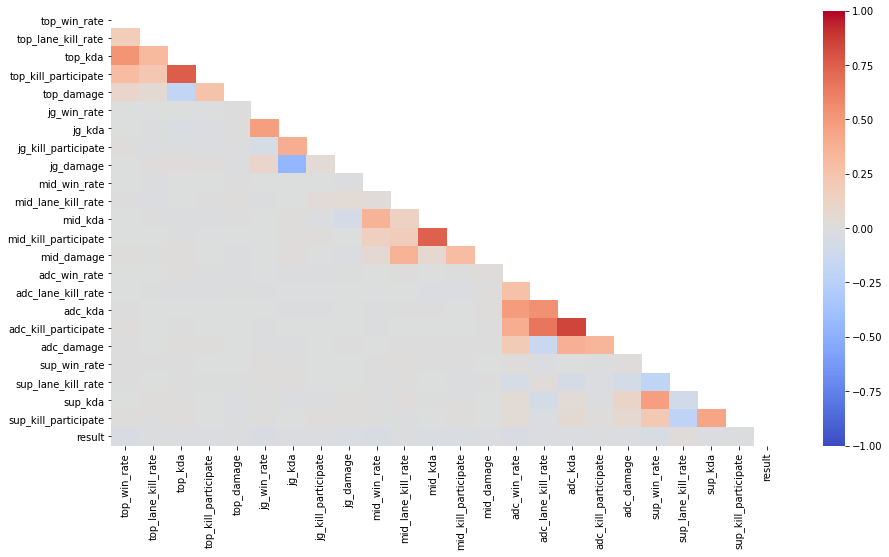

In [47]:
plt.figure(figsize=(15,8))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

#### Jg damage 跟 Jg kda呈負相關 JG的擊殺多半是搶頭
#### Support的 Lane kill rate會導致 自己的 win rate下降  代表搶自己AD的人頭的確可能降低勝率
#### AD 和 Support的數據彼此較有關連  其他位置彼此間則沒有太大關係  跟預期符合

### 運用模型本身對各路進行分析

我們預設的輸入是23項(上路5項、打野4項、中路5項、下路5項、輔助4項)，現在我們假設每一路的對線都均勢，也就是說全部都輸入0.5，得到的勝率為0.49(紅色方的勝率)。我們很好奇，若僅改變一路的對線數據，其他四路皆當作均勢的話，會得到怎樣的效果。所以說我們就去抓取opgg有統計的所有對線數據(內容包括是哪兩個英雄對線，以及是哪一條路，還有4-5項相關數據)，將僅改變上路的所有勝率數據做成散布圖，其他路也以此類推，得到以下圖表(紅色代表上路、橘色代表打野、黃色代表中路、綠色代表下路、藍色代表輔助):

![Image of Scatter](https://lh3.googleusercontent.com/q0kFN3-8C7hF1c9guVYIYh9UNiXCtDvkcOPwoHnZUZMkteMOWL1RrzHpd7pyTnJ8UVDHb-ZzfrFa72mUM7DRUqPng1TnI2CaCwvXBUwuEJRo485NJjXP3s_FQb7t_3IRj0AjBMrE)
#### 我們觀察此圖，可以發現紅色代表的上路、黃色代表的中路勝率變動明顯較大，也就是說，模型學習到了此兩路的對線英雄組合，對於遊戲勝率的影響較大。
考量到現實的情況，上路跟中路都是兩個英雄赤裸裸在線上對決，兩英雄的天生優劣性，可能會相對較影響遊戲的走勢。打野並無直接碰撞(雖兩英雄對決優劣會影響到野區博弈，但考量到rank上的打野觀念參差不齊(相較比賽上)，兩打野觀念的影響性可能遠大於英雄優劣的影響性)，下路是雙英雄對決雙英雄，各自英雄的搭配性也會有影響(如發育型ADC偏好保護型輔助)。這樣分析下來，模型算是有學習到一點實際情況。


### 主成分分析

In [48]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [50]:
df2 = preprocessing.scale(df)
pca = PCA(n_components=5)
pca.fit(df2)
score = pca.transform(df2)

In [51]:
print(pca.explained_variance_ratio_)
pca_result = pd.concat((pd.DataFrame(df.iloc[:, 0:-1].columns, columns = ['Variable']), 
                pd.DataFrame(abs(pca.components_.T), columns = ['PC1','PC2','PC3','PC4','PC5'])), 
                axis = 1).sort_values(by='PC1', ascending = False)

pca_result.reset_index().drop(["index"],axis=1)

[0.1153905  0.09375702 0.08633781 0.07872357 0.07075373]


,Variable,PC1,PC2,PC3,PC4,PC5
0,adc_kda,0.556193,0.008626,0.007604,0.017734,0.008506
1,adc_kill_participate,0.555954,0.008174,0.001127,0.069060,0.011930
2,adc_lane_kill_rate,0.415687,0.021382,0.028245,0.155820,0.003306
3,adc_win_rate,0.374278,0.002988,0.014290,0.024938,0.001272
4,adc_damage,0.246773,0.012170,0.028794,0.139071,0.007546
5,sup_lane_kill_rate,0.049509,0.007371,0.028592,0.306509,0.026121
6,sup_kill_participate,0.047216,0.023984,0.039958,0.498356,0.047552
7,sup_kda,0.032570,0.022188,0.052364,0.577897,0.040869
8,NaN,0.025462,0.029253,0.051754,0.037377,0.043552
9,jg_kda,0.017013,0.058674,0.042135,0.068311,0.728011


#### 從主成分分析可以看出在這個版本中整個遊戲的影響力有  AD > TOP > MID > SUP > JG 的趨勢 而且影響力落差最大的地方是AD和TOP之間
這和我們模型間跑取出來的結果似乎有些出入。 不過根據Riot官方公布的消息指出，雖然AD的影響力在最近幾個版本中應該是偏低的，不過考量到End Game需要有人推塔，而這個部分是需要AD來做，這或許也部分詮釋了為何TOP跟MID的勝率變異比其他路的來的大。 
結論: TOP跟MID帶的風向對遊戲勝負很重要，但最終還是得回到推塔的本質，如果AD沒辦法快速推塔End Game那TOP跟MID帶的風向便會失去。

### 其他分類模型分析

#### 隨機森林

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [53]:
X = df[df.columns[0:-1]]
Y = df["result"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

In [54]:
rfc = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=10)
rfc = rfc.fit(x_train,y_train)
train_score = rfc.score(x_train, y_train)
test_score = rfc.score(x_test, y_test)
print('R^2 Training Score:{}'.format(train_score),'R^2 Validation Score:{}'.format(test_score))

# print()
# rfc.feature_importances_

rfc_result = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                pd.DataFrame(rfc.feature_importances_.T, columns = ['Importance'])), 
                axis = 1).sort_values(by='Importance', ascending = False)

rfc_result.reset_index().drop(["index"],axis=1)

R^2 Training Score:0.9861638458073235 R^2 Validation Score:0.5195041924899745


,Variable,Importance
0,top_win_rate,0.048107
1,top_damage,0.047980
2,sup_win_rate,0.046672
3,top_lane_kill_rate,0.045336
4,mid_damage,0.044750
5,jg_damage,0.044716
6,mid_kda,0.044556
7,mid_win_rate,0.044539
8,sup_lane_kill_rate,0.044446
9,top_kill_participate,0.044116


#### 羅吉斯回歸

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [56]:
lr= LogisticRegression(C=5,
                        n_jobs=1,
                        random_state=22,
                        class_weight='balanced'
                        )
lr.fit(x_train, y_train)
# Scoring
train_score = cross_val_score(lr, x_train, y_train, cv=10).mean()
test_score = lr.score(x_test, y_test)
print('R^2 Training Score:{}'.format(train_score),'R^2 Validation Score:{}'.format(test_score))

R^2 Training Score:0.5347185793096934 R^2 Validation Score:0.5318993802406125


In [57]:
print(lr.intercept_)

lr_result = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                pd.DataFrame(lr.coef_.T, columns = ['Coefficient']),
                pd.DataFrame(abs(lr.coef_.T), columns = ['Importance'])), 
                axis = 1).sort_values(by='Importance', ascending = False)

lr_result.reset_index().drop(["index"],axis=1)

[6.41340987]


,Variable,Coefficient,Importance
0,adc_win_rate,-2.490804,2.490804
1,sup_win_rate,-2.202328,2.202328
2,jg_kda,-1.854163,1.854163
3,top_win_rate,-1.499479,1.499479
4,jg_damage,-1.434529,1.434529
5,adc_kill_participate,1.322134,1.322134
6,mid_win_rate,-1.316035,1.316035
7,adc_damage,-1.130770,1.130770
8,mid_damage,-1.024804,1.024804
9,mid_kda,-0.729464,0.729464


#### 可以看出其他的分類模型出來的結果大概也在50幾趴左右浮動，可見得可能是蒐集的資料對於預測勝敗結果並沒有那麼有幫助，所以在各種分類模型裏頭都沒有好的太傑出的表現

## 【實作心得】

### 企管四 林展玄
  整個實作的過程中本組花了很多時間在思考到底該蒐集什麼數據才能幫助我們提升模型預測的準確度以及資料蒐集上面，最終決定花比較費工的方法上OP.GG爬取兩隻英雄在某路的對抗數據而非英雄本身自己的數據，並且也把各國伺服器和版本問題給統一了。此外，我自己主要負責的GUI介面也是花了不少時間去研究TKinter該如何撰寫。最終的結果不如最初預期可能跟我們沒有花太多時間去選擇最佳的AI模型以及如何調參有關。不過在整個實作過程中，遇到最大的困難其實也是這個部分，雖然整個學期介紹了很多不同的模型並介紹背後的數學原理，但是在實作過程中到底該如何選擇適切的模型以及如何調參卻沒什麼提到。如果課堂上能多介紹一些比賽的實作案例，並把業界和學界歸納出來在實作時該如何選擇適合的模型以及調整參數的概念教給同學，我覺得收穫會更多一點。

### 資管三 羅恩力
 這次報告我覺得收穫不少。
 1.一開始我研究了有關requests的爬蟲方法，並且嘗試使用numpy套件和pandas套件把資料轉換成適合跑ai的格式。途中我也不斷修改精簡我的CODE內容，我從別的地方看到更好的寫法，就趕快把它運用到CODE裡，到了最後我的寫法是把收集的資料以list儲存下來，再以NUMPY reshape成合適的大小，並轉成PANDAS。最後以PANDAS強大的資料篩檢能力，整理出最簡潔的資料供AI使用。
 2.一開始我先以幾千筆資料跑跑看MODEL，果然效果不彰，五十左右的準確率。原本以為是資料不夠多的因素，但在以兩萬多筆資料跑仍無提昇時，就大概得知我們這次大概研究不出十分精準的MODEL了。我想到另外一堂課的教授有提過，這可能跟資料本身有關係，我們收集下來的資料不夠正確，或是這些數據就跟結果沒有太多的關聯。
 3.蠻有趣的是，另外一個同學使用selenium實現抓取需要點擊才能抓取的數據，我的作法不一樣，研究過程也蠻曲折的，我當初在點擊時，查看網頁是GET到哪些資料，並且發現這個網站是前後端分離的架構，GET到的數據是透過AJAX，去跑某網頁(也就是所謂的調用後端API接口)。所以說只要request 這些網頁，一樣也可以收集那些點擊才能抓取的數據。這些概念剛好跟我最近在開發的系上專案有所關聯，幫助我能更好更快理解研究WEB架構，算是相輔相成。


### 經濟一 黃柏翰
  這次小組我是負責進階爬蟲的部分。原本另一個組員已經寫完爬蟲，進度大超前，因為我沒分配到大項目的工作又想學一些東西於是組員決定讓我用selenium進行爬蟲。不過對於沒有爬蟲經驗我真的是一大問題，因為在使用selenium時 模擬一般使用者的點擊滑動等操作都是需要在它的網頁碼中找尋 CSS 或html的相關code，因此我必須建立相關背景知識後才能開始爬蟲。而後我使用bs4 時發現時間都以時間戳的方法紀錄剛好可以解決request的盲點。因為在用request(另一個組員)爬蟲沒辦法找出在特定日期間(與LOL版本有關)內打的場次，因此為了解決此次問題因此改用selenium這個套件來爬蟲。而在後續爬蟲時就比較像是一般寫code一些迴圈判斷式等等的問題就走得比較順暢了，只有debug de到崩潰的問題但最後還是寫出來了。最後我也有參與一些ai建模，不過我發現最難的部分根本不在ai的使用上，全部都在蒐集資料及分析，因此這個學期讓我深深的體會ai真的是一個好工具，不過最終還是要回歸到本身的專業知識才能解析為甚麼這個AI的結果是這樣以及分析後續的原因



### 資管三 洪濬中
  這次的小組報告，讓我從中學習到很多東西，也了解到自己有許多的不足，但是也體會到為自己的目標一點一點的學習，看著小組的專案一點點的成形是一件開心的事情，不過比較可惜的事情是，感覺自己在coding的方面真的有待加強。
